# 결정 트리


결정 트리(Decision Tree)란 분류와 회귀 작업, 다중 출력 작업이 가능한 머신러닝 알고리즘이다.

**결정트리의 장점**

1. 매우 복잡한 데이터셋도 학습할 수 있다.

2. 만들어진 모델을 쉽게 시각화할 수 있다.

3. 데이터 전처리(스케일링)가 불필요하다.

<br>

**결정 트리의 단점**

1. 훈련 세트의 회전에 민감하다

   - 훈련 세트를 회전시키면 결정 경계가 바뀌기 때문에 결정 경계의 일반화가 어렵다.(그럼에도 훈련 세트는 완벽하게 학습한다.)

   - 훈련 데이터를 더 좋은 방향으로 회전시키는 PCA 기법을 사용하여 이 단점을 극복할 수 있다.

2. 훈련 세트의 작은 변화에도 민감하다.

   - 훈련 데이터의 작은 변화에도 결정 경계가 많이 바뀌기 때문에 일반화가 어렵다.

   - 이를 극복하기 위해 훈련 데이터를 더 많이 모아야 한다.

<br>

**훈련 계산 복잡도**

- 훈련시에는 각 노드에서 모든 훈련 샘플의 모든 특성을 비교기에 $O(n \times m \log(m))$의 훈련 복잡도를 가진다.

- 훈련 세트가 작을 경우 데이터를 정렬하여 훈련 속도를 높일 수 있다.

<br>

**예측 계산 복잡도**

- 결정 트리를 탐색하기 위해서는 약 $O(log_2(m))$ 개의 노드를 거쳐야 한다.

- 전체 복잡도는 특성 수와 무관하다. 그렇기에 큰 훈련 세트를 다룰 때에도 예측 속도가 빠른다.


In [1]:
# 해당셀은 기본적인 라이브러리와 setup을 수행하는 코드로 구성되어 있습니다.
# Base setup
CHAPTER_ID = "week7"

# Load system modules
import os
import sys


# Load modules for data handling
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


# Path setup
main_path = os.getcwd().split(
    'muchine_learninng_notebook')[0] + 'muchine_learninng_notebook/codes'
datasets_path = os.path.join(main_path, 'datasets')

sys.path.append(main_path)


# graph setup
# 깔금한 그래프 출력을 위해
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Set seed
np.random.seed(42)
random_seed = 42

In [14]:
# 결정 트리를 그리는 함수
from matplotlib.colors import ListedColormap


def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y == 1], X[:, 1][y == 1],
                 "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y == 2], X[:, 1][y == 2],
                 "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

## 데이터 준비


결정 트리를 알아보기 위하여 붓꽃 데이터셋을 사용할 것이다.

본 문서의 목적은 붓꼿을 꽃잎의 길이와 너비 기준으로 분류하는 모델을 만들며 결정 트리 알고리즘을 사용하는 방법을 숙지하는 것이다.

데이터를 불러와보자.


In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, 2:]  # 꽃잎 길이와 너비
y = iris.target

print(f'Shape: {X.shape, y.shape}')
print(f'Data sample: {X[0], y[0]}')

Shape: ((150, 2), (150,))
Data sample: (array([1.4, 0.2]), 0)


## 결정 트리 분류


### 결정 트리 학습


sklearn의 DecisionTreeClassifier 모델을 활용하여 결정 트리를 이용한 분류를 수행할 수 있다.


In [3]:
from sklearn.tree import DecisionTreeClassifier

# max_depth: 트리의 최대 깊이(연속된 가지치기가 최대 2번까지 가능하다.)
# random_state: 랜덤 시드
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

### 결정 트리 시각화


위와 같이 생성된 결정트리는 export_graphviz() 함수를 통해 시각화 할 수 있다. 시각화된 이미지는 아래와 같다.

<img width="60%" src="https://raw.githubusercontent.com/jaewonE/muchine_learning_notebook/main/codes/images/decision_trees/decision_trees_visual.png">


각각의 노드 내에 명시된 속성은 다음과 같다.

- gini(gini 점수): 해당 노드의 불순도 측정값

  - $G_i = 1 - \sum\limits_{k=1}^{n}{{p_{i,k}}^2}$

  - 모든 샘플이 동일 클래스에 속하면 불순도가 0이 된다.(gini = 0)

  - depth를 내려갈수록(커질수록) 각각의 노드의 gini 값은 감소한다.

  - gini 점수가 낮으면 낮을수록 분류가 잘 수행된 것이다.

  - 연속된 결정트리 학습 과정에 사용되는 알고리즘의 비용함수에 사용된다.

    - gini 값이 낮아지는 방향으로 학습한다.

    - gini 값이 임계치 이상 변화하지 않을 때 학습을 중단한다.

- samples: 해당 노드 결정에 사용된 샘플 수

- value: 해당 노드 마다 결정에 사용된 샘플을 클래스 별로 구분한 결과

  - 훈련 샘플을 레이블 정보를 이용하여 분류한다.

- class: 각 클래스별 비율을 계산하여 가장 높은 비율에 해당하는 클래스를 선정한다.

  - 동일한 비율일 경우 낮은 인덱스를 선정한다.


### 결정 트리의 결정 경계


결정 트리의 결정 경계가 어떻게 형성되어 있는지 시각적으로 확인한 뒤, 결정 트리가 예측을 수행하는 과정에 대해 알아보자.

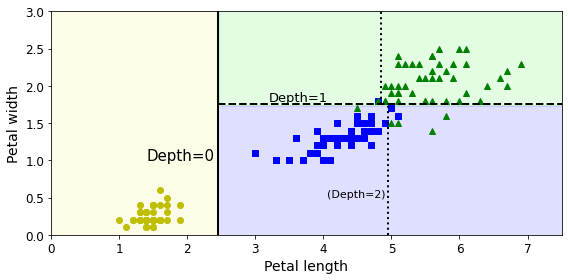


데이터가 주어지면 나무뿌리에서 시작한다.

나무뿌리는 위 이미지의 depth=0 선 위에서 시작한다. 위의 결정 트리 시각화에서 나무 뿌리의 분류 기준이 petal_length <= 2.45(cm) 였으므로, petal_length가 2.45(cm)보다 작거나 같은지 확인하는 것이 depth=0에서 수행하는 일이다.

<br>

depth=0일 때 petal_length <= 2.45(cm) 조건을 확인한다.

- 조건을 만족한다면 노랑색 영역으로 이동하여 lris-Versicolor로 품종을 판단한다.

- 조건을 만족하지 않는다면 초록과 보라색 영역으로 이동하여 depth=1일 때 수행하는 내용을 수행한다.

<br>

depth=1일 때는 petal_width <= 1.75(cm) 조건을 확인한다.

- 조건을 만족한다면 보라색 영역으로 이동하여 lris-Setosa로 품종을 판단한다.

- 조건을 만족하지 않는다면 초록색 영역으로 이동하여 lris-Virginica로 품종을 판단한다.

> 가지가 더 이상 존재하지 않기에 depth=1이 최종 깊이가 된어 분류를 종료한다.


### 예측 수행


predict_proba 함수를 통해 개별 데이터의 예측 확률을 구할 수 있으며 predict 함수를 통해 예측 클래스를 구할 수 있다.

> np.argmax(predict_proba(...)) == predict(...)


In [11]:
print(tree_clf.predict_proba([[5, 1.5]])[0])
print()
print('Predicted class:', tree_clf.predict([[5, 1.5]])[0])

[0.         0.90740741 0.09259259]

Predicted class: 1


### CART 알고리즘


결정 트리의 비용함수를 최적화(최소화) 하는 알고리즘에 탐욕 알고리즘(greedy algorithm)을 적용한 것을 CART(Classification And Regression Trees) 알고리즘이라고 한다.

> 위에서 사용한 sklearn의 DecisionTreeClassifier는 CART 알고리즘을 기반으로 한다.

CART 알고리즘의 비용 함수는 아래와 같이 정의된다.

$$J(k, t_k) = \dfrac{m_{\text{left}}}{m}G_\text{left} + \dfrac{m_{\text{right}}}{m}G_{\text{right}}$$

- $G_\text{left/right}$는 왼쪽/오른쪽 서브셋의 불순도

- $m_\text{left/right}$는 왼쪽/오른쪽 서브셋의 샘플 수

CART 알고리즘은 자신 노드보다 더 작은 불순도를 가지는 두 개의 부분집합으로 분할된다.

max_depth 깊이에 다다르거나 불순도를 줄이는 불할을 더 이상 찾을 수 없을 때까지 반복한다.


### Gini 불순도와 Entropy

결정 트리는 기본적으로 지니 불순도를 사용하여 비용 함수를 정의한다.

하지만 분류를 수행할 때 많이 사용되는 엔트로피 불순도도 비용 함수로 사용할 수 있다.

엔트로피 식은 다음과 같이 정의된다.

$$H_i = -\sum_{k=1}^{n}P_{i,k}\log(P_{i,k})$$

- sklearn의 DecisionTreeClassifier는 criterion="entropy" 옵션을 통해 Gini 불순도가 아닌 Entropy 불순도를 사용할 수 있다.

- Gini 불순도와 Entropy 불순도는 큰 차이가 없으며, Gini 불순도가 계산 속도가 조금 더 빠르다.

- Entropy 불순도가 Gini 불순도에 비해 조금 더 균형 잡힌 트리를 만들 수 있다.


### 규제가 있는 결정 트리 분류


결정 트리는 훈련 데이터에 대한 제약 사항이 없으므로 과대적합(overfitting)이 발생하기 쉽다.

과대적합을 막기 위해 결정 트리의 자유도를 제한하는 것을 통해 규제(regularization)를 가한다.

미지 정의된 모델 파라미터에 자유도를 제한함으로써 결정 트리의 과대적합을 막고자 하였으며 이를 **매개변수(parametric model) 모델**이라고 부른다.

> 훈련되기 전에 파라미터 수가 결정되어 있지 않아 데이터에 맞춰 모델 구조가 결정되는 모델을 **비매개변수(nonparametric model)모델**이라고 부른다.


sklearn의 DecisionTreeClassifier는 규제를 위해 다음과 같은 옵션를 제공한다.

- max_depth: 결정 트리의 최대 높이 제한

- min_samples_split: 노드를 분할하기 위해 필요한 최소 샘플 수

- min_samples_leaf: 리프 노드가 가지고 있어야 할 최소 샘플 수

- min_weight_fraction_leaf: min_samples_leaf와 같지만 가중치가 부여된 전체 샘플 수에서의 비율

- max_leaf_nodes: 허용된 리프 노드의 최대 개수

- max_features: 각 노드에서 분할 평가에 사용될 수 있는 최대 특성 수

<br>

min\_ 접두사가 포함된 옵션은 매개변수를 증가시켜 과대적합을 제어하는데 사용되며

max\_ 접두사가 포함된 옵션은 매개변수를 감소시켜 과소적합을 제어하는데 사용된다.

예제를 하나씩 보자.

> sample수가 1개이면 gini score가 0이 되어 더 이상 분할하지 않는 문제가 발생하기도 하며 sample수가 지나치게 작아 gini score가 너무 큰 문제도 발생한다.


그림 저장: min_samples_leaf_plot


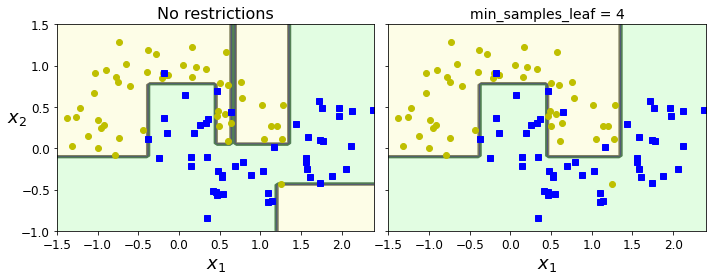

In [15]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym,
                       axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym,
                       axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(
    deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

min_samples_leaf 통해 최소 샘플 수를 지정하여 과대적합을 방지한 것을 확인할 수 있다.


## 결정 트리 회귀


In [16]:
# 잡음이 포함된 2차식 데이터셋을 생성한다.
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

print(f'Shape: {X.shape, y.shape}')
print(f'Data sample: {X[0], y[0]}')

Shape: ((200, 1), (200, 1))
Data sample: (array([0.37454012]), array([-0.00504175]))


### 결정 트리 회귀 학습


결정 트리는 회귀 문제에서도 사용될 수 있다.

sklearn의 DecisionTreeRegressor를 통해 결정 트리 회귀를 수행할 수 있으며 사용 방법은 동일하다.

다만 회귀를 수행하기에 Gini score를 통해 비용함수를 정의하는 것이 아닌 MSE를 통해 비용함수를 정의한다.


In [17]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

### 결정 트리 회귀 시각화


생성된 결정 트리를 시각화하면 아래와 같이 나타난다.

- 회귀와 같이 gini score가 아닌 mse를 사용한다.

- value는 해당 마디에 속한 훈련 샘플의 **평균 타깃값**이다.

<img width="60%" src="https://raw.githubusercontent.com/jaewonE/muchine_learning_notebook/main/codes/images/end_to_end_project/DecisionTreeRegressor.png">


### 결정 트리 회귀의 결정 경계


결정 트리 회귀의 결정 경계는 아래와 같다. max_depth 값이 커질수록 결정 경계가 복잡해지는 것을 확인할 수 있다.

- 실선이 depth=0, 굵은 점선이 depth=1, 연한 점선이 depth=2이다.


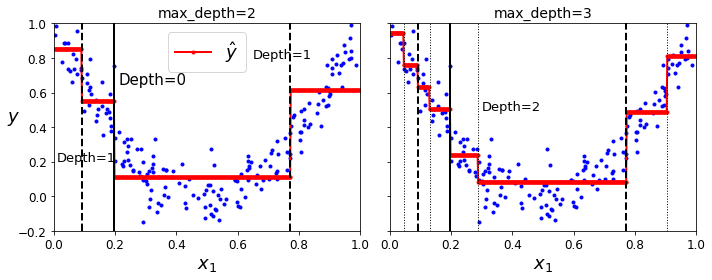


### CART 알고리즘


회귀에서도 CART 알고리즘을 적용할 수 있다.

동일하게 탐욕적 알고리즘(greedy algorithm)을 사용하여 비용함수를 최소화 하는 특성 k와 해당 특성의 임곗값 $t_K$을 결정한다.

다만 Gini가 아닌 MSE를 이용하여 비용함수를 아래와 같이 정의한다.

$$J(k, t_k) = \dfrac{m_{\text{left}}}{m}\text{MSE}_\text{left} + \dfrac{m_{\text{right}}}{m}\text{MSE}_{\text{right}}$$


### 결정 트리 회귀 규제


분류에서와 동일하게 결정 트리 회귀에서도 과대적합이 발생한다.

이에 결정 트리 분류와 동일하게 파라미터를 통해 모델을 규제하여 과대적합을 방지할 수 있다.

sklearn의 DecisionTreeRegressor에서sms DecisionTreeClassifier와 동일한 파라미터를 사용하여 규제를 적용할 수 있다.

아래는 규제가 적용되지 않은 결정 트리 회귀 모델과 min_samples_leaf=10을 통해 규제를 적용한 모델의 결정 경계를 비교한 것이다.

규제가 적용되었을 때, 더 일반적으로 예측을 수행함을 확인할 수 있다.

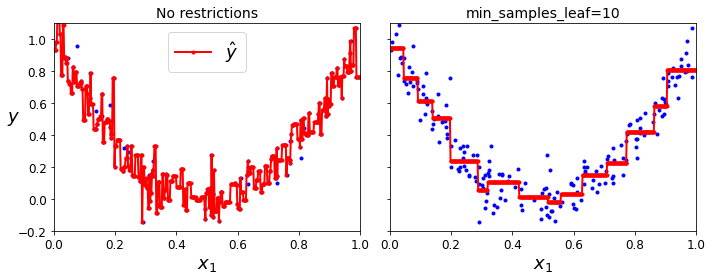


## 연습문제


sklearn의 DecisionTreeClassifier 를 이용하여 sklearn의 make_moons 데이터셋을 수행해보자.


In [42]:
# 먼저 데이터를 불러와 확인해보자.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# 데이터셋 생성
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Train set, Test set 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
print(f'Shape: {X.shape, y.shape}')
print(f'Data sample: {X[0], y[0]}')

Shape: ((1000, 2), (1000,))
Data sample: (array([-0.11166654,  0.52022374]), 1)


In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# DecisionTreeClassifier 학습
tree_clf = DecisionTreeClassifier(max_depth=3,         # 최대 깊이는 6
                                  min_samples_split=32,  # 노드를 분할하기 위한 최소 샘플 수는 32
                                  min_samples_leaf=4,  # 리프 노드가 되기 위한 최소 샘플 수는 4
                                  random_state=42)     # random seed
tree_clf.fit(X_train, y_train)


y_pred = tree_clf.predict(X_test)  # 예측
accuracy = accuracy_score(y_test, y_pred)  # 정확도 계산
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9150


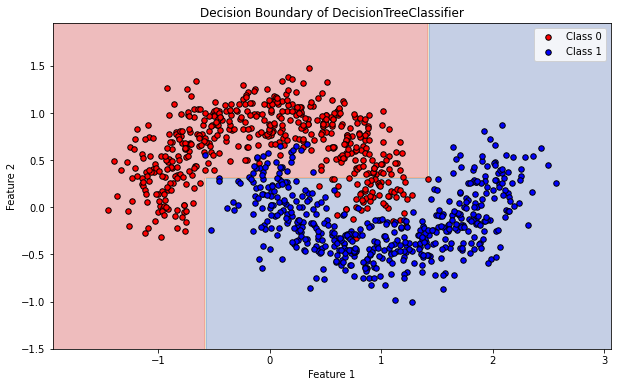

In [66]:
def plot_decision_boundary_updated(clf, X, y, plot_title, subplot_loc=None):
    plot_colors = ["#FFAAAA", "#AAAAFF"]
    plot_step = 0.02

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    if subplot_loc == None:
        plt.figure(figsize=(10, 6))
    else:
        plt.subplot(*subplot_loc)
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.3)

    scatter_colors = ['red', 'blue']
    for i, color in zip(range(2), scatter_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color,
                    edgecolor='black', s=30, marker='o', label=f"Class {i}")

    plt.title(plot_title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    if subplot_loc == None:
        plt.show()


plot_decision_boundary_updated(
    tree_clf, X, y, "Decision Boundary of DecisionTreeClassifier")

##### max_depth 값의 변화

max_depth 값을 변화하며 최적의 max_depth 값을 찾아보자.


Max depth: 3, Accuracy: 0.9150
Max depth: 4, Accuracy: 0.8800
Max depth: 5, Accuracy: 0.9700
Max depth: 6, Accuracy: 0.9750


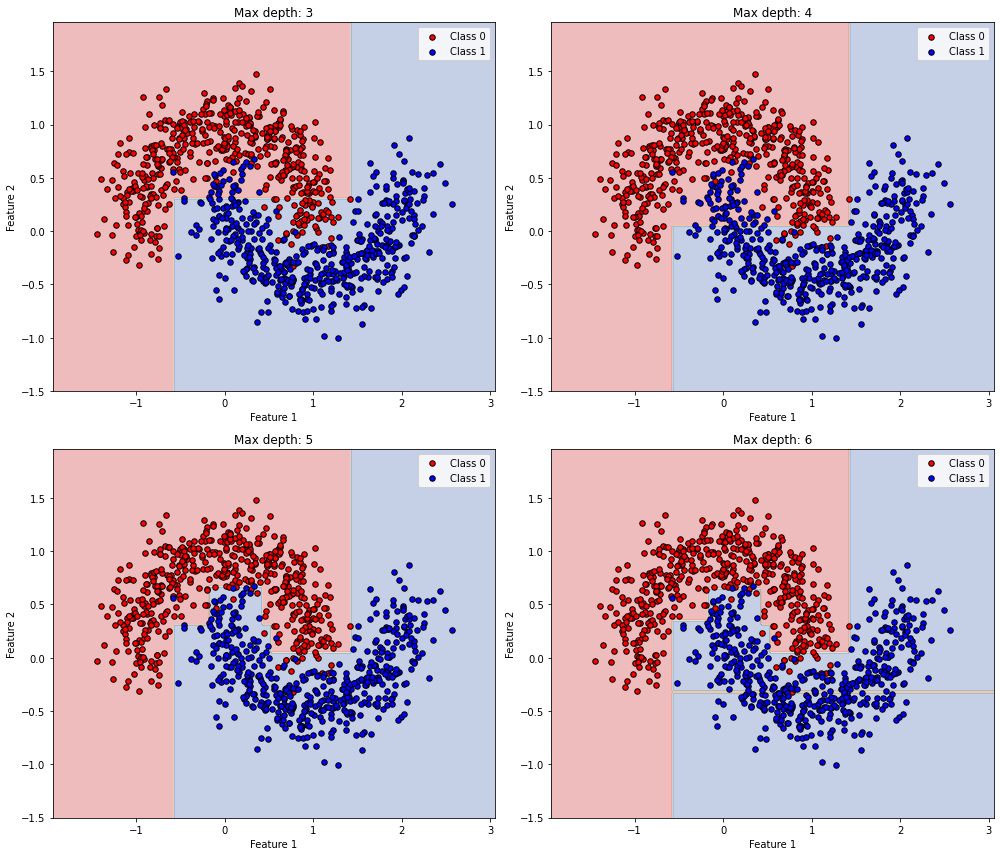

In [67]:
max_depth_list = [3, 4, 5, 6]

# 전체 그래프 크기 설정
plt.figure(figsize=(14, 12))

for idx, max_depth in enumerate(max_depth_list):
    tree_clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    tree_clf.fit(X_train, y_train)
    y_pred = tree_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Max depth: {max_depth}, Accuracy: {accuracy:.4f}')

    plot_decision_boundary_updated(
        tree_clf, X, y, f'Max depth: {max_depth}', (2, 2, idx+1))

plt.tight_layout()
plt.show()